# Gaussian Process Regression for Rossman Sales Dataset
Here we use Gaussian Process Regression to model daily store sales for the Rossman Stores dataset provided on Kaggle. This algorithm is definitely one of the worst approaches to this problem, but it is illustrative to show how we can use prior knowledge about the problem to creatively design our kernel to model the data.

# Preliminaries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

%matplotlib inline  
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

sales_data = pd.read_csv("C:/Users/Jacob Stern/Downloads/store_train.csv")
test_data = pd.read_csv("C:/Users/Jacob Stern/Downloads/store_test.csv")

TRAIN_SIZE = 10000
SAMPLE_SIZE = 500
sigma_sqr = 1

sample_train_indices = np.random.choice(len(sales_data), TRAIN_SIZE, replace=False)
sample_indices = np.random.choice(len(sales_data), SAMPLE_SIZE, replace=False) #Generate a random list of indices for the data
store_data = sales_data.iloc[sample_train_indices, :].values
sample_data = (sales_data.iloc[sample_indices, :]).values
test_data = test_data.values
Y = store_data[:,3]
#print(sample_data[1,:])

Populating the interactive namespace from numpy and matplotlib


C:\Users\Public\Documents\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create Kernel

In [0]:
def dowKernel( matrix1, matrix2, dictionary ):
    index1 = dictionary[0].index("DOW")
    index2 = dictionary[1].index("DOW")
    m1 = np.zeros((7, len(matrix1[:,0])), dtype=int)
    m2 = np.zeros((7, len(matrix2[:,0])), dtype=int)
    #This part is hard to follow, but it uses a mask to avoid using a for loop to make our one-hot matrix.
    #row 1 is the column of matrix1 holding the day of the week
    #The row index of m1 is given by the value stored in matrix1[:,1] for all values in matrix[:,1] (numbers 1 through 7). 
    #The column index of matrix1 iterates through the length of matrix 1.
    m1[matrix1[:,index1].astype(int) - 1, np.arange(len(matrix1[:,0]))] = 1       
    m2[matrix2[:,index2].astype(int) - 1, np.arange(len(matrix2[:,0]))] = 1
    return np.dot(np.transpose(m1), m2)

def Kernel( matrix1, matrix2, dictionary ):
    return dowKernel(matrix1, matrix2, dictionary)
#This is a simple kernel, but it is built so I can beef it up when I have more time to work on it, adding in other kernels

# Display Kernel

In [0]:
train_to_train_dict = [["Store", "DOW", "Date", "Sales", "Customers", "Open", "Promo", "State Holiday", "School Holiday"],["Store", "DOW", "Date", "Sales", "Customers", "Open", "Promo", "State Holiday", "School Holiday"]]
train_to_test_dict = [["Store", "DOW", "Date", "Sales", "Customers", "Open", "Promo", "State Holiday", "School Holiday"],["Id", "Store", "DOW", "Date", "Open", "Promo", "State Holiday", "School Holiday"]]

Kmn = Kernel(sample_data, store_data, train_to_train_dict)
Knm = np.transpose(Kmn)
Kmm = Kernel(sample_data, sample_data, train_to_train_dict)

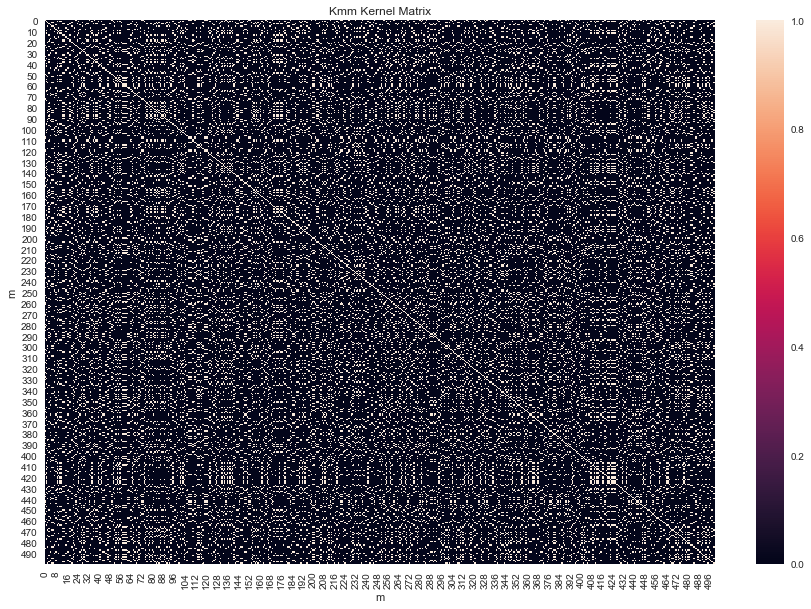

In [0]:
fig1, ax = plt.subplots(1, 1, figsize=(15, 10))
ax = sns.heatmap(Kmm)
ax.set_ylabel("m")
ax.set_xlabel("m")
ax.set_title("Kmm Kernel Matrix")
plt.show()

In [0]:
x = ((np.dot(Kmn,Knm) + sigma_sqr*Kmm))
y = np.dot(np.linalg.pinv(x), np.dot(Kmn, Y))

# Compute Mu-prime

In [0]:
mu_prime = np.dot(np.transpose(Kernel(sample_data, test_data, train_to_test_dict)),y)

# Write to File

In [0]:
sfile = open( "C:/Users/Jacob Stern/Downloads/sales_predictions.csv", 'w' )
sfile.write( '"Id","Sales"\n' )
for id in range( 0, len(test_data) ):
    sfile.write( '%d,%.2f\n' % ( id+1, mu_prime[id] ) )  # add one for one-based indexing
sfile.close()

In [0]:
from datetime import datetime
store_one["date"] = pd.to_datetime(store_one["date"])
#print(store_one.date.head())
store_one.index = store_one.date      #sets the dataframe to be indexed by date

graph = store_one.sales.plot(title="Store 1 Sales Over Time")
#graph.plot_date(store_one.date, store_one.sales, fmt='-', xdate=True, ydate=False)
plt.gca().invert_xaxis()
graph.set_ylabel("Sales ($)")
graph.set_xlabel("Date")
graph.legend()